## Homework

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX' -O data.csv

--2022-05-11 17:44:29--  https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX
Resolving docs.google.com (docs.google.com)... 142.250.81.206, 2607:f8b0:4004:82f::200e
Connecting to docs.google.com (docs.google.com)|142.250.81.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dqd0g2tkkuqnsah5lg39vnlhuo573svc/1652291025000/03856158561714992485/*/1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX?e=download [following]
--2022-05-11 17:44:30--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dqd0g2tkkuqnsah5lg39vnlhuo573svc/1652291025000/03856158561714992485/*/1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX?e=download
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 142.251.45.97, 2607:f8b0:4004:83f::2001
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercont

В этой домашней работе вы будете предсказывать стоимость домов по их характеристикам.

Метрика качества: `RMSE`

Оценивание:
* Baseline - 2 балла
* Feature Engineering - 2 балла
* Model Selection - 3 балла
* Ensemble v.1 - 3 балла
* (*) Ensemble v.2 - дополнительно, 2 балла

### Описание датасета

Короткое описание данных:
```
price: sale price (this is the target variable)
id: transaction id
timestamp: date of transaction
full_sq: total area in square meters, including loggias, balconies and other non-residential areas
life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
floor: for apartments, floor of the building
max_floor: number of floors in the building
material: wall material
build_year: year built
num_room: number of living rooms
kitch_sq: kitchen area
state: apartment condition
product_type: owner-occupier purchase or investment
sub_area: name of the district

The dataset also includes a collection of features about each property's surrounding neighbourhood, and some features that are constant across each sub area (known as a Raion). Most of the feature names are self explanatory, with the following notes. See below for a complete list.

full_all: subarea population
male_f, female_f: subarea population by gender
young_*: population younger than working age
work_*: working-age population
ekder_*: retirement-age population
n_m_{all|male|female}: population between n and m years old
build_count_*: buildings in the subarea by construction type or year
x_count_500: the number of x within 500m of the property
x_part_500: the share of x within 500m of the property
_sqm_: square meters
cafe_count_d_price_p: number of cafes within d meters of the property that have an average bill under p RUB
trc_: shopping malls
prom_: industrial zones
green_: green zones
metro_: subway
_avto_: distances by car
mkad_: Moscow Circle Auto Road
ttk_: Third Transport Ring
sadovoe_: Garden Ring
bulvar_ring_: Boulevard Ring
kremlin_: City center
zd_vokzaly_: Train station
oil_chemistry_: Dirty industry
ts_: Power plant
```

### Setup

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("data.csv", parse_dates=["timestamp"])

In [ ]:
print(df.shape)
df.head()

(20000, 292)


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price
0,0,2014-12-26,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,36,7,2,15,33,1,12,75,10,15318960
1,1,2012-10-04,64,64.0,16.0,NaN,NaN,NaN,NaN,NaN,...,2,2,0,0,13,1,0,6,1,6080000
2,2,2014-02-05,83,44.0,9.0,17.0,1.0,1985.0,3.0,10.0,...,13,6,1,8,18,0,1,52,0,17000000
3,3,2012-07-26,71,49.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,3,0,2,8,2,990000
4,4,2014-10-29,60,42.0,9.0,9.0,1.0,1970.0,3.0,6.0,...,3,1,0,5,8,0,1,34,5,7900000


Разделите имеющиеся у вас данные на обучающую и тестовую выборки. В качестве обучающей выборки возьмите первые 80% данных, последние 20% - тестовая выборка.

In [ ]:
drop_columns = [
    'id',           # May leak information
    'timestamp',    # May leak information
]

cat_columns = [
    'product_type',              #
    'material',                  # Material of the wall
    'state',                     # Satisfaction level
    'sub_area',                  # District name
    'culture_objects_top_25',    #
    'thermal_power_plant_raion', #
    'incineration_raion',        #
    'oil_chemistry_raion',       #
    'radiation_raion',           #
    'railroad_terminal_raion',   #
    'big_market_raion',          #
    'nuclear_reactor_raion',     #
    'detention_facility_raion',  #
    'ID_metro',                  #
    'ID_railroad_station_walk',  #
    'ID_railroad_station_avto',  #
    'water_1line',               #
    'ID_big_road1',              #
    'big_road1_1line',           #
    'ID_big_road2',              #
    'railroad_1line',            #
    'ID_railroad_terminal',      #
    'ID_bus_terminal',           #
    'ecology',                   #
]

num_columns = list(set(df.columns).difference(set(cat_columns + drop_columns)))

In [ ]:
X = df.drop(columns = ['price', 'id', 'timestamp'])
X = pd.get_dummies(X, columns = cat_columns)
y = df.price.values

In [ ]:
X.shape

(20000, 1064)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(16000, 1064)
(4000, 1064)


Возможно в ваших моделях вам придется указывать, какие колонки являются категориальными (например, в бустингах). Для упрощения предлагается разделить колонки по следующему принципу:
```
drop_columns = [
    'id',           # May leak information
    'timestamp',    # May leak information
]
cat_columns = [
    'product_type',              #
    'material',                  # Material of the wall
    'state',                     # Satisfaction level
    'sub_area',                  # District name
    'culture_objects_top_25',    #
    'thermal_power_plant_raion', #
    'incineration_raion',        #
    'oil_chemistry_raion',       #
    'radiation_raion',           #
    'railroad_terminal_raion',   #
    'big_market_raion',          #
    'nuclear_reactor_raion',     #
    'detention_facility_raion',  #
    'ID_metro',                  #
    'ID_railroad_station_walk',  #
    'ID_railroad_station_avto',  #
    'water_1line',               #
    'ID_big_road1',              #
    'big_road1_1line',           #
    'ID_big_road2',              #
    'railroad_1line',            #
    'ID_railroad_terminal',      #
    'ID_bus_terminal',           #
    'ecology',                   #
]
num_columns = list(set(df.columns).difference(set(cat_columns + drop_columns)))
```

In [ ]:
X_test.isna().any().sum()

48

In [ ]:
X_train.isna().any().sum()

48

In [ ]:
# Заполняем все пропуски в данных средними значениями для каждого признака
from sklearn.impute import SimpleImputer 

mis_replacer = SimpleImputer(strategy="mean")
X_train = pd.DataFrame(data=mis_replacer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=mis_replacer.fit_transform(X_test), columns=X_test.columns)

### Baseline (2 балла)

В качестве Baseline обучите `DecisionTreeRegressor` из `sklearn`.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import matplotlib.pyplot as plt

In [ ]:
clf = DecisionTreeRegressor(max_depth=2, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=42)

Проверьте качество на отложенной выборке.

In [ ]:
clf.score(X_test, y_test)

0.363395727596754

In [ ]:
np.mean(cross_val_score(clf, X_test, y_test, cv=5))

0.3623212138156834

### Feature Engineering (2 балла)

Часто улучшить модель можно с помощью аккуратного Feature Engineering.

Добавим в модель дополнительные признаки:
* "Как часто в этот год и этот месяц появлились объявления"
* "Как часто в этот год и эту неделю появлялись объявления"

In [ ]:
month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df["week_year_cnt"] = week_year.map(week_year_cnt_map)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


Добавьте следюущие дополнительные признаки:
* Месяц (из колонки `timestamp`)
* День недели (из колонки `timestamp`)
* Отношение "этаж / максимальный этаж в здании" (колонки `floor` и `max_floor`)
* Отношение "площадь кухни / площадь квартиры" (колонки `kitchen_sq` и `full_sq`)

По желанию можно добавить и другие признаки.

In [ ]:
df["month"] = df.timestamp.dt.month
df["day_of_week"] = df.timestamp.dt.dayofweek
df["floor/max_floor"] = df["floor"] / df["max_floor"]
df["kitchen_sq/full_sq"] = df["kitch_sq"] / df["full_sq"]

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace = True)

Разделите выборку на обучающую и тестовую еще раз (потому что дополнительные признаки созданы для исходной выборки).

In [ ]:
X = df.drop(columns = ['price', 'id', 'timestamp'])
X = pd.get_dummies(X, columns = cat_columns)
y = df.price.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
mis_replacer = SimpleImputer(strategy="mean")
X_train = pd.DataFrame(data=mis_replacer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=mis_replacer.fit_transform(X_test), columns=X_test.columns)

### Model Selection (3 балла)

Посмотрите, какого качества можно добиться если использовать разные модели:
* `DecisionTreeRegressor` из `sklearn`
* `RandomForestRegressor` из `sklearn`
* `CatBoostRegressor`

Также вы можете попробовать линейные модели, другие бустинги (`LigthGBM` и `XGBoost`).

Почти все библиотеки поддерживают удобный способ подбора гиперпараметров: посмотрите как это делать в [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) или в [catboost](https://catboost.ai/docs/concepts/python-reference_catboostregressor_grid_search.html).

Проверяйте качество каждой модели на тестовой выборке и выберите наилучшую.

In [ ]:
pip install catboost

     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

Посмотрим на метрики разных алгоритмов

In [ ]:
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
cb = CatBoostRegressor(random_state=42)

clf_dict = {0: 'DecisionTreeRegressor', 1: 'RandomForestRegressor', 2: 'CatBoostRegressor'}
models = [dt, rf, cb]

for i, model in enumerate(models):
  print("{} | Тестовая точность измерений MAE: {}".format(clf_dict[i], -cross_val_score(model, X_train, y_train, cv = cv, scoring="neg_mean_absolute_error", n_jobs=-1).mean()))
  print("{} | Тестовая точность измерений MSE: {}".format(clf_dict[i], -cross_val_score(model, X_train, y_train, cv = cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()))
  print("{} | Тестовая точность измерений R2: {}".format(clf_dict[i], cross_val_score(model, X_train, y_train, cv = cv, scoring="r2", n_jobs=-1).mean()))
  print()

DecisionTreeRegressor | Тестовая точность измерений MAE: 1984981.7594375
DecisionTreeRegressor | Тестовая точность измерений MSE: 14364032875595.057
DecisionTreeRegressor | Тестовая точность измерений R2: 0.34912446104606604

RandomForestRegressor | Тестовая точность измерений MAE: 1440437.3981703036
RandomForestRegressor | Тестовая точность измерений MSE: 7640429409608.128
RandomForestRegressor | Тестовая точность измерений R2: 0.6537258859358059

CatBoostRegressor | Тестовая точность измерений MAE: 1389510.1186149055
CatBoostRegressor | Тестовая точность измерений MSE: 6710680628671.268
CatBoostRegressor | Тестовая точность измерений R2: 0.6959289548164064



В дальнейшем будем использовать метрику R2

Попробуем уменьшить количество признаков. Удалим признаки, которые сильно коррелируют друг с другом

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif

In [ ]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Удаление коллинеарующих объектов в датафрейме с коэффициентом корреляции
        больше порогового значения. Удаление коллинеарующих объектов может помочь модели
        обобщиться и улучшить интерпретируемость.

    Inputs: 
        x: датафрейм
        threshold: объекты с корреляциями, превышающими это значение, удаляются

    Output: 
        датафрейм, содержащий только не очень коллинеарующие объекты
    '''

    # Вычисляем корреляционную матрицу
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Выполняем итерацию по корреляционной матрице и сравниваем корреляции
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # Если корреляция превышает пороговое значение
            if val >= threshold:
                # Выводим коррелирующие объекты и значение корреляции
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Выбрасываем по одному из каждой пары коррелирующих столбцов
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [ ]:
X_train_new = remove_collinear_features(X_train, 0.8)

children_preschool | raion_popul | 0.95
preschool_education_centers_raion | raion_popul | 0.84
preschool_education_centers_raion | children_preschool | 0.84
children_school | raion_popul | 0.96
children_school | children_preschool | 0.99
children_school | preschool_education_centers_raion | 0.83
school_quota | preschool_quota | 0.93
school_education_centers_raion | raion_popul | 0.82
school_education_centers_raion | children_preschool | 0.82
school_education_centers_raion | preschool_education_centers_raion | 0.96
school_education_centers_raion | children_school | 0.81
office_raion | culture_objects_top_25_raion | 0.9
male_f | full_all | 1.0
female_f | full_all | 1.0
female_f | male_f | 1.0
young_all | raion_popul | 0.96
young_all | children_preschool | 1.0
young_all | preschool_education_centers_raion | 0.84
young_all | children_school | 1.0
young_all | school_education_centers_raion | 0.82
young_male | raion_popul | 0.96
young_male | children_preschool | 1.0
young_male | preschool_ed

In [ ]:
X_train_new.shape

(16000, 713)

In [ ]:
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
cb = CatBoostRegressor(random_state=42)

clf_dict = {0: 'DecisionTreeRegressor', 1: 'RandomForestRegressor', 2: 'CatBoostRegressor'}
models = [dt, rf, cb]

for i, model in enumerate(models):
  print("{} | Тестовая точность измерений R2: {}".format(clf_dict[i], cross_val_score(model, X_train_new, y_train, cv = cv, scoring="r2", n_jobs=-1).mean()))

DecisionTreeRegressor | Тестовая точность измерений R2: 0.3385920757046234
RandomForestRegressor | Тестовая точность измерений R2: 0.6534364745348622
CatBoostRegressor | Тестовая точность измерений R2: 0.6927466528406707


Таким образом, мы удалили 357 признаков и почти не потеряли в точности

In [ ]:
import time
import datetime
from sklearn.linear_model import Lasso

In [ ]:
def grid_search(model, gs_params):
    '''Функция для подбора гиперпараметров с помощью перекрёстной проверки'''
     
    gs = GridSearchCV(estimator=model, param_grid=gs_params,
                      scoring='r2', n_jobs=-1, cv=cv, verbose=0)
    gs.fit(X_train_new, y_train)
    scores = [gs.cv_results_[f'split{i}_test_score'][gs.best_index_] for i in range(5)]
    print('scores = {}, \nmean score = {:.5f} +/- {:.5f} \
           \nbest params = {}'.format(scores,
                                      gs.cv_results_['mean_test_score'][gs.best_index_],
                                      gs.cv_results_['std_test_score'][gs.best_index_],
                                      gs.best_params_))
    return gs

In [ ]:
lr = Pipeline([('lr', Lasso(random_state=42))])

In [ ]:
lr_params = {'lr__alpha': list(map(lambda i: 10 ** i, range(-3, 6)))}
             
print('grid search results for lr')
lr_grid = grid_search(model=lr, gs_params=lr_params)

grid search results for lr
scores = [0.4144801014197964, 0.4474847651966539, 0.45633018245394663, -2.6516850347935184, 0.45183625931868887], 
mean score = -0.17631 +/- 1.23778            
best params = {'lr__alpha': 100000}


R2 отрицательная, потому что модель получилась очень плохая, и она в разы увеличивает дисперсию наших данных 👎

Попробуем убрать ещё больше признаков

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
lr_selector = SelectFromModel(estimator=lr_grid.best_estimator_['lr'], prefit=True, threshold=0.1)

# посмотрим выбранные признаки признаки
data = pd.DataFrame(data={'score':lr_selector.estimator.coef_[0],
                   'support':lr_selector.get_support()}, 
             index=X_train_new.columns).sort_values(by='score',ascending=False)
data

,score,support
full_sq,468688.037776,True
ID_railroad_station_walk_52.0,468688.037776,False
ID_railroad_station_walk_29.0,468688.037776,False
ID_railroad_station_walk_30.0,468688.037776,False
ID_railroad_station_walk_31.0,468688.037776,False
...,...,...
thermal_power_plant_raion_no,468688.037776,False
radiation_raion_no,468688.037776,False
railroad_terminal_raion_no,468688.037776,False
big_market_raion_no,468688.037776,False


Оставим только важные призанки

In [ ]:
index = data[data['support'] == False].index
X_train_new2 = X_train_new.drop(index, axis=1)
X_train_new2.shape

(16000, 107)

Получилось обрезать X_train до 107 признаков

**DecisionTreeRegressor**

In [ ]:
param = { 'max_depth': range(1, 20, 2),
          'min_samples_leaf': range(1, 100, 10) }
dt = DecisionTreeRegressor(random_state=42)
dt_cv = GridSearchCV(dt, param, cv=cv, scoring="r2")
dt_cv.fit(X_train_new2,y_train)

print("best parameters: ", dt_cv.best_params_)
print("r2:", dt_cv.best_score_)

best parameters:  {'max_depth': 11, 'min_samples_leaf': 61}
r2: 0.5627495201995794


In [ ]:
best_dt = DecisionTreeRegressor(max_depth = 11, min_samples_leaf = 61, random_state=42)
best_dt.fit(X_train_new2, y_train)

np.mean(cross_val_score(best_dt, X_test, y_test, cv=cv, scoring="r2", n_jobs=-1))

0.5135636408784672

**RandomForestRegressor**

In [ ]:
param = { 'n_estimators': range (35, 46),
          'max_depth': range (8,16) }
rf = RandomForestRegressor(random_state=42)
rf_cv = GridSearchCV(rf, param, cv=cv, scoring="r2")
rf_cv.fit(X_train_new2,y_train)

print("best parameters: ", rf_cv.best_params_)
print("r2:", rf_cv.best_score_)

best parameters:  {'max_depth': 14, 'n_estimators': 44}
r2: 0.6545137348188523


In [ ]:
best_rf = RandomForestRegressor(max_depth = 14, n_estimators = 44, random_state=42)
best_rf.fit(X_train_new2, y_train)

np.mean(cross_val_score(best_rf, X_test, y_test, cv=cv, scoring="r2", n_jobs=-1))

0.5923760602202204

**CatBoostRegressor**

In [ ]:
param = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
cb = CatBoostRegressor(random_state=42, logging_level='Silent')
grid_search_result = cb.grid_search(param, X=X_train_new2, cv=cv, y=y_train)

0:	loss: 2669287.9853654	best: 2669287.9853654 (0)	total: 11s	remaining: 5m 19s
1:	loss: 2645330.5123548	best: 2645330.5123548 (1)	total: 16s	remaining: 3m 44s
2:	loss: 2698577.5058470	best: 2645330.5123548 (1)	total: 21s	remaining: 3m 9s
3:	loss: 2672439.8112508	best: 2645330.5123548 (1)	total: 25.9s	remaining: 2m 48s
4:	loss: 2717130.8599597	best: 2645330.5123548 (1)	total: 30.9s	remaining: 2m 34s
5:	loss: 2688183.6523051	best: 2645330.5123548 (1)	total: 35.9s	remaining: 2m 23s
6:	loss: 2715467.7498708	best: 2645330.5123548 (1)	total: 40.9s	remaining: 2m 14s
7:	loss: 2669397.0833088	best: 2645330.5123548 (1)	total: 45.9s	remaining: 2m 6s
8:	loss: 2720496.3278724	best: 2645330.5123548 (1)	total: 50.7s	remaining: 1m 58s
9:	loss: 2649418.0384597	best: 2645330.5123548 (1)	total: 55.7s	remaining: 1m 51s
10:	loss: 2666274.2646391	best: 2645330.5123548 (1)	total: 1m 4s	remaining: 1m 52s
11:	loss: 2684828.8140861	best: 2645330.5123548 (1)	total: 1m 13s	remaining: 1m 50s
12:	loss: 2679421.620

In [ ]:
grid_search_result

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [ ]:
best_cb = CatBoostRegressor(depth = 6, l2_leaf_reg = 5, learning_rate = 0.1, logging_level='Silent', random_state=42)
best_cb.fit(X_train_new2, y_train)

np.mean(cross_val_score(best_cb, X_test, y_test, cv=cv, scoring="r2", n_jobs=-1))

0.6205375661529178

CatBoostRegressor с параметрами {depth = 6, l2_leaf_reg = 5, learning_rate = 0.1} получилась лучшей моделью 

---



### Ensemble v.1 (3 балла)

Ансамбли иногда оказываются лучше чем одна большая модель.

В колонке `product_type` содержится информация о том, каким является объявление: `Investment` (продажа квартиры как инвестиции) или `OwnerOccupier` (продажа квартиры для жилья). Логично предположить, что если сделать по модели на каждый из этих типов, то качество будет выше.

Обучите свои лучшие модели на отдельно на `Investment` и `OwnerOccupier` (т.е. у вас будет `model_invest`, обученная на `(invest_train_X, invest_train_Y)` и `model_owner`, обученная на `(owner_train_X, owner_train_Y)`) и проверьте качество на отложенной выборке (т.е. на исходном `test_split`).

In [ ]:
X = df.drop(columns = ['id', 'timestamp'])
X = pd.get_dummies(X, columns = cat_columns)

In [ ]:
invest_X = X[X['product_type_Investment'] == 1]
invest_Y = invest_X.price.values
invest_X = invest_X.drop(columns = ['price'])
invest_train_X, invest_test_X, invest_train_Y, invest_test_Y = train_test_split(invest_X, invest_Y, test_size=0.2, random_state=42)

owner_X = X[X['product_type_OwnerOccupier'] == 1]
owner_Y = owner_X.price.values
owner_X = owner_X.drop(columns = ['price'])
owner_train_X, owner_test_X, owner_train_Y, owner_test_Y = train_test_split(owner_X, owner_Y, test_size=0.2, random_state=42)

Получили два набора данных invest_ и owner_

In [ ]:
invest_train_X.shape

(10272, 1070)

In [ ]:
owner_train_X.shape

(5728, 1070)

In [ ]:
invest_train_X = pd.DataFrame(data=mis_replacer.fit_transform(invest_train_X), columns=invest_train_X.columns)
invest_test_X = pd.DataFrame(data=mis_replacer.fit_transform(invest_test_X), columns=invest_test_X.columns)

owner_train_X = pd.DataFrame(data=mis_replacer.fit_transform(owner_train_X), columns=owner_train_X.columns)
owner_test_X = pd.DataFrame(data=mis_replacer.fit_transform(owner_test_X), columns=owner_test_X.columns)

Обучаем лучшие модели

In [ ]:
invest_train_X = pd.DataFrame(scaler.fit_transform(invest_train_X), index=invest_train_X.index, columns=invest_train_X.columns)

owner_train_X = pd.DataFrame(scaler.fit_transform(owner_train_X), index=owner_train_X.index, columns=owner_train_X.columns)

**DecisionTreeRegressor**

In [ ]:
model_invest = DecisionTreeRegressor(max_depth = 11, min_samples_leaf = 61, random_state=42)
model_invest.fit(invest_train_X, invest_train_Y)

DecisionTreeRegressor(max_depth=11, min_samples_leaf=61, random_state=42)

In [ ]:
model_owner = DecisionTreeRegressor(max_depth = 11, min_samples_leaf = 61, random_state=42)
model_owner.fit(owner_train_X, owner_train_Y)

DecisionTreeRegressor(max_depth=11, min_samples_leaf=61, random_state=42)

Для каждой из моделей получим предсказания для X_test и найдем среднее между ними

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
y_pred_invest = model_invest.predict(X_test)
y_pred_owner = model_owner.predict(X_test)
y_pred_rf = (y_pred_invest + y_pred_owner ) * 0.5

r2_score(y_test, y_pred_rf)

-7.159125035164564

Почему-то стало хуже:((

**RandomForestRegressor**

In [ ]:
model_invest = RandomForestRegressor(max_depth = 14, n_estimators = 44, random_state=42)
model_invest.fit(invest_train_X, invest_train_Y)

RandomForestRegressor(max_depth=14, n_estimators=44, random_state=42)

In [ ]:
model_owner = RandomForestRegressor(max_depth = 14, n_estimators = 44, random_state=42)
model_owner.fit(owner_train_X, owner_train_Y)

RandomForestRegressor(max_depth=14, n_estimators=44, random_state=42)

In [ ]:
y_pred_invest = model_invest.predict(X_test)
y_pred_owner = model_owner.predict(X_test)
y_pred_rf = (y_pred_invest + y_pred_owner ) * 0.5

r2_score(y_test, y_pred_rf)

-20.544389064029858

**CatBoostRegressor**

In [ ]:
model_invest = CatBoostRegressor(depth = 6, l2_leaf_reg = 5, learning_rate = 0.1, logging_level='Silent', random_state=42)
model_invest.fit(invest_train_X, invest_train_Y)

In [ ]:
model_owner = CatBoostRegressor(depth = 6, l2_leaf_reg = 5, learning_rate = 0.1, logging_level='Silent', random_state=42)
model_owner.fit(owner_train_X, owner_train_Y)

In [ ]:
y_pred_invest = model_invest.predict(X_test)
y_pred_owner = model_owner.predict(X_test)
y_pred_rf = (y_pred_invest + y_pred_owner ) * 0.5

r2_score(y_test, y_pred_rf)

-3.738879798615156

Ни одна из моделей не улучшилась:((

### (*) Ensemble v.2 (дополнительно, 2 балла)

Попробуйте сделать для `Investment` более сложную модель: обучите `CatBoostRegressor` и `HuberRegressor` из `sklearn`, а затем сложите их предсказания с весами `w_1` и `w_2` (выберите веса сами; сумма весов равняется 1).

In [ ]:
from sklearn.linear_model import HuberRegressor
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

**HuberRegressor**

In [ ]:
h_model_invest = HuberRegressor(max_iter = 4000)
h_model_invest.fit(invest_train_X, invest_train_Y)

r2_score(invest_test_Y, h_model_invest.predict(invest_test_X))

-52801132773.18645

In [ ]:
h_model_invest = HalvingGridSearchCV( HuberRegressor(max_iter = 3000),
                                      [{'epsilon':np.arange(1, 5, 0.1),
                                        'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
                                      ], scoring = 'r2', cv = cv )
h_model_invest.fit(invest_train_X, invest_train_Y)

HalvingGridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                    estimator=HuberRegressor(max_iter=3000),
                    param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                           100.0, 1000.0],
                                 'epsilon': array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9])}],
                    scoring='r2')

In [ ]:
h_model_invest.best_score_

0.32055430733012563

In [ ]:
h_model_invest.best_estimator_

HuberRegressor(alpha=0.01, epsilon=2.100000000000001, max_iter=3000)

In [40]:
model_invest = HuberRegressor(alpha = 0.01, epsilon = 2.100000000000001, max_iter = 3000)
model_invest.fit(invest_train_X, invest_train_Y)

model_owner = HuberRegressor(alpha = 0.01, epsilon = 2.100000000000001, max_iter = 3000)
model_owner.fit(owner_train_X, owner_train_Y)

y_pred_invest_h = model_invest.predict(X_test)
y_pred_owner_h = model_owner.predict(X_test)

**CatBoostRegressor**

In [37]:
param = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
cb = CatBoostRegressor(random_state=42, logging_level='Silent')
grid_search_result = cb.grid_search(param, X=invest_train_X, cv=cv, y=invest_train_Y)

0:	loss: 2726069.3638670	best: 2726069.3638670 (0)	total: 26s	remaining: 12m 33s
1:	loss: 2772784.8354144	best: 2726069.3638670 (0)	total: 50.1s	remaining: 11m 41s
2:	loss: 2750190.4497129	best: 2726069.3638670 (0)	total: 1m 17s	remaining: 11m 41s
3:	loss: 2746903.7449116	best: 2726069.3638670 (0)	total: 1m 58s	remaining: 12m 50s
4:	loss: 2754337.9806416	best: 2726069.3638670 (0)	total: 2m 22s	remaining: 11m 52s
5:	loss: 2726446.8646355	best: 2726069.3638670 (0)	total: 2m 46s	remaining: 11m 6s
6:	loss: 2763042.7867508	best: 2726069.3638670 (0)	total: 3m 10s	remaining: 10m 26s
7:	loss: 2747458.6184985	best: 2726069.3638670 (0)	total: 3m 34s	remaining: 9m 50s
8:	loss: 2757630.4365096	best: 2726069.3638670 (0)	total: 3m 59s	remaining: 9m 18s
9:	loss: 2749549.4362801	best: 2726069.3638670 (0)	total: 4m 23s	remaining: 8m 46s
10:	loss: 2746835.5434159	best: 2726069.3638670 (0)	total: 5m 17s	remaining: 9m 9s
11:	loss: 2775431.1366652	best: 2726069.3638670 (0)	total: 6m 12s	remaining: 9m 18s
1

In [38]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03}

In [39]:
model_invest = CatBoostRegressor(depth = 6, l2_leaf_reg = 3, learning_rate = 0.03, logging_level='Silent', random_state=42)
model_invest.fit(invest_train_X, invest_train_Y)

model_owner = CatBoostRegressor(depth = 6, l2_leaf_reg = 3, learning_rate = 0.03, logging_level='Silent', random_state=42)
model_owner.fit(owner_train_X, owner_train_Y)

y_pred_invest_cb = model_invest.predict(X_test)
y_pred_owner_cb = model_owner.predict(X_test)

Теперь найдём веса

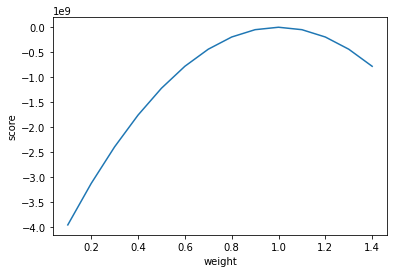

In [61]:
scores = {}
weights = np.arange(0.1, 1.5, 0.1)

for w in weights:
  y_pred_invest = w * y_pred_invest_cb + (1 - w) * y_pred_invest_h
  y_pred_owner = w * y_pred_owner_cb + (1 - w) * y_pred_owner_h
  y_pred = (y_pred_invest + y_pred_owner ) * 0.5
  score = r2_score(y_test, y_pred)
  scores[w] = score

pd.Series(scores).plot()
plt.xlabel('weight')
plt.ylabel('score')
plt.show()

"Относительно(!)" нормальная метрика получается если мы зануляем HuberRegressor. Значит распределим веса так:

In [62]:
y_pred_invest = 0.99 * y_pred_invest_cb + 0.01 * y_pred_invest_h
y_pred_owner = 0.99 * y_pred_owner_cb + 0.01 * y_pred_owner_h
y_pred = (y_pred_invest + y_pred_owner ) * 0.5

r2_score(y_test, y_pred)

-485815.74359504675

Всё получилось совсем плохо, надеюсь, я когда-нибудь пойму почему